In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

**Train and Test Datasets**

In [2]:
#train Dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,
                                        transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:03<00:00, 43797707.93it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
#Test Data set
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True,
                                        transform=transforms.ToTensor())

Files already downloaded and verified


# Creating Dataloaders

In [4]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size, shuffle = False)


# Approach to Processing Each Channel Separately
Here's a way to implement this idea in a feedforward neural network using PyTorch:

* Separate Pathways for Each Channel: Create three different pathways in the network to process each channel separately.
* Combine Features: Concatenate or add the features from each pathway.
* Final Layers: Pass the combined features through the final layers to produce the output.

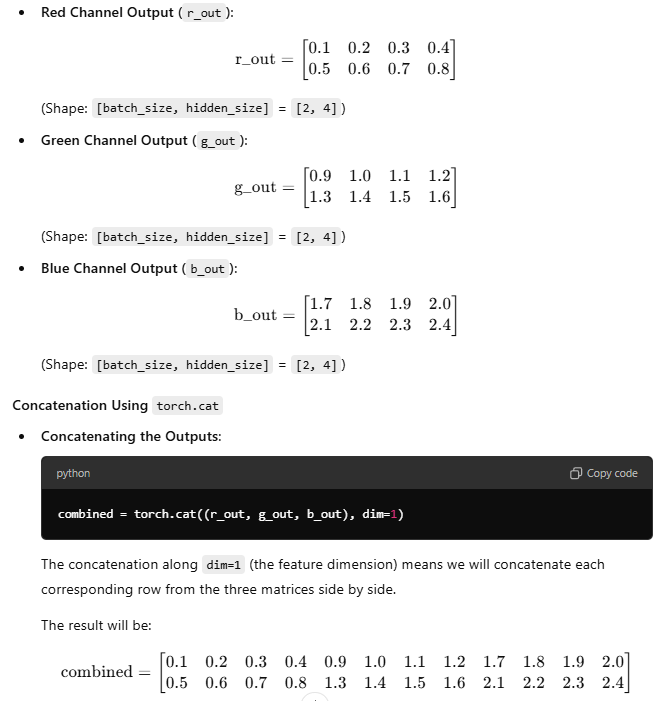

# Model:

neural network model is designed to handle RGB images by processing each color channel (Red, Green, and Blue) separately, combining their features, and then using these combined features for further processing and final classification.

In [5]:
#hyper parameters
input_size_per_channel = 32*32
hidden_size1 = 512
hidden_size2 = 256
output_size = 10


# Our NN model
class channel_NN(nn.Module):
  def __init__(self, input_size_per_channel, hidden_size1, hidden_size2, output_size):
    super().__init__()
    # seperate layer for each channel
    self.red_layer = nn.Linear(input_size_per_channel, hidden_size1)
    self.green_layer = nn.Linear(input_size_per_channel, hidden_size1)
    self.blue_layer = nn.Linear(input_size_per_channel, hidden_size1)

    #final layer
    self.hidden_layer = nn.Linear(hidden_size1*3, hidden_size2) #combining layer for all the channels
    self.output_layer = nn.Linear(hidden_size2, output_size)

  def forward(self, xb): # xb = image of batch size(128)
    # split the input into three channels(512, 3, 32, 32)
    # xb is a tensor  representing a batch of images (batch_size, channels, height, width)
    red = xb[:, 0, :, :].view(-1, input_size_per_channel)
    green = xb[:,1,:,:].view(-1, input_size_per_channel)
    blue = xb[:,2,:,:].view(-1, input_size_per_channel)

    # forward pass through each cahnnels layer
    outr = F.relu(self.red_layer(red))
    outg = F.relu(self.green_layer(green))
    outb = F.relu(self.blue_layer(blue))

    #concanate the output from each channel
    out_concanated = torch.cat(( outr, outg, outb), dim = 1)
    # now we  will pass the concanated output to the hidden layer
    out_of_hidden = F.relu(self.hidden_layer(out_concanated))
    out = self.output_layer(out_of_hidden)
    return out

  def training_step(self, batch):
    images, labels = batch # here we are getiing 128(batch size) images in one go
    out = self.forward(images)
    loss = F.cross_entropy(out, labels)
    _, pred = torch.max(out, dim = 1)
    acc = torch.tensor(torch.sum(pred == labels).item()/len(pred))
    return {'loss': loss, 'acc' : acc}

  def training_epoch_end(self, output):
    batch_losses = [x['loss'] for x in output]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['acc'] for x in output]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'loss': epoch_loss.item(), 'acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
     print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}".format(
        epoch, result['loss'], result['acc']))

In [6]:
model = channel_NN(input_size_per_channel, hidden_size1, hidden_size2, output_size)
model

channel_NN(
  (red_layer): Linear(in_features=1024, out_features=512, bias=True)
  (green_layer): Linear(in_features=1024, out_features=512, bias=True)
  (blue_layer): Linear(in_features=1024, out_features=512, bias=True)
  (hidden_layer): Linear(in_features=1536, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
)

In [7]:
for t in model.parameters():
  print(t.shape)

torch.Size([512, 1024])
torch.Size([512])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([256, 1536])
torch.Size([256])
torch.Size([10, 256])
torch.Size([10])


In [8]:
for param in model.parameters():
    print(param.requires_grad)


True
True
True
True
True
True
True
True
True
True


In [9]:
def evaluate(model, train_loader):
  output = [model.training_step(batch) for batch in train_loader]
  return model.training_epoch_end(output)

def fit(epochs, lr, model, train_loader):
  history = []
  optimizer = optim.SGD(model.parameters(), lr)
  for epoch in range(epochs):
    for batch in train_loader:

      # Compute the loss and accuracy for the current batch
      loss_dict = model.training_step(batch)
      loss = loss_dict['loss']# Extract the loss tensor from the dictionary

      # Backpropagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Evaluate the model after each epoch
    result = evaluate(model, train_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [10]:
history = fit(60, 0.01, model, train_loader)

Epoch [0], train_loss: 2.1575, train_acc: 0.2365
Epoch [1], train_loss: 2.0055, train_acc: 0.2983
Epoch [2], train_loss: 1.9376, train_acc: 0.3086
Epoch [3], train_loss: 1.8806, train_acc: 0.3382
Epoch [4], train_loss: 1.8576, train_acc: 0.3432
Epoch [5], train_loss: 1.8211, train_acc: 0.3528
Epoch [6], train_loss: 1.7862, train_acc: 0.3692
Epoch [7], train_loss: 1.7685, train_acc: 0.3744
Epoch [8], train_loss: 1.7497, train_acc: 0.3780
Epoch [9], train_loss: 1.7240, train_acc: 0.3880
Epoch [10], train_loss: 1.7107, train_acc: 0.3920
Epoch [11], train_loss: 1.6794, train_acc: 0.4086
Epoch [12], train_loss: 1.6513, train_acc: 0.4164
Epoch [13], train_loss: 1.6687, train_acc: 0.4043
Epoch [14], train_loss: 1.6215, train_acc: 0.4297
Epoch [15], train_loss: 1.6254, train_acc: 0.4293
Epoch [16], train_loss: 1.5868, train_acc: 0.4445
Epoch [17], train_loss: 1.5732, train_acc: 0.4434
Epoch [18], train_loss: 1.5595, train_acc: 0.4541
Epoch [19], train_loss: 1.5488, train_acc: 0.4564
Epoch [20]